## Creating general direction steering vectors


We want to create a set of mazes and then find steering vectors for going in a direction. This would be done by averaging the activations in different mazes everytime they go in a specific direction. Say, finding a general "right" vector, could be done by finding all instances in every maze where the model does a "right step". We can do this for each direction (right, left, up, down). In addition, to enforce a direction, we can subtract its negative counterpart, e.g. steer_up = up_vector - down_vector. 

In [317]:
%env

{'COMMAND_MODE': 'unix2003',
 'HOME': '/Users/benjamin.berczi',
 'HOMEBREW_CELLAR': '/opt/homebrew/Cellar',
 'HOMEBREW_PREFIX': '/opt/homebrew',
 'HOMEBREW_REPOSITORY': '/opt/homebrew',
 'INFOPATH': '/opt/homebrew/share/info:',
 'LOGNAME': 'benjamin.berczi',
 'LaunchInstanceID': '74E4E318-53B5-4B19-8242-DEFF82A98823',
 'MANPATH': '/opt/homebrew/share/man::',
 'MallocNanoZone': '0',
 'OLDPWD': '/',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/opt/homebrew/bin:/Users/benjamin.berczi/Library/Python/3.11/bin:/Users/benjamin.berczi/.rd/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Users/benjamin.berczi/.rd/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bi

In [318]:
import os 
PYTORCH_ENABLE_MPS_FALLBACK=1
CUDA_VISIBLE_DEVICES=""
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"


In [319]:
import sys
sys.path

sys.path.append("/Users/benjamin.berczi/Documents/maze-dataset")
sys.path.append("/Users/benjamin.berczi/Documents/maze-transformer-1")
sys.path.append("/Users/benjamin.berczi/Documents/research")
sys.path.append("/Users/benjamin.berczi/Documents/research/unsearch_research")


In [320]:
# Imports
%load_ext autoreload
%autoreload 2

# General Utilities
from pathlib import Path

# Generic ML
import numpy as np
import torch
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('medium') # if your GPU has TensorCores

# Maze Transformer and Dataset

# Other useful things
from muutils.nbutils.configure_notebook import configure_notebook
from unsearch_research import *

# other package imports
import matplotlib.pyplot as plt # keep this import for CI to work
from zanj import ZANJ # saving/loading data
from muutils.mlutils import pprint_summary # pretty printing as json

# maze_dataset imports

from maze_dataset import LatticeMaze, SolvedMaze, MazeDataset, MazeDatasetConfig
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.generation import LatticeMazeGenerators, GENERATORS_MAP
from maze_dataset.generation.default_generators import DEFAULT_GENERATORS
from maze_dataset.dataset.configs import MAZE_DATASET_CONFIGS
from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes

from unsearch_research.stable.analysis import intervene_upon_generation

from matplotlib.gridspec import GridSpec


# check the configs
print(MAZE_DATASET_CONFIGS.keys())
# for saving/loading things
zanj: ZANJ = ZANJ(external_list_threshold=256)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['test-g3-n5-a_dfs-h75556', 'demo_small-g3-n100-a_dfs-h88371', 'demo-g6-n10K-a_dfs-h30615'])


In [321]:
# Configuration
SEED = 42
DARK_MODE = True
LOCAL_DATA_PATH = Path("/Users/benjamin.berczi/Documents")
#LOCAL_DATA_PATH: str = "../data/maze_dataset"

DEVICE = configure_notebook(
    seed=SEED,
    dark_mode=DARK_MODE,
    device=None,  # Defaults GPU > MPS > CPU
)
set_unsearch_style(dark_mode=DARK_MODE) # Matplotlib style

set up plots with PLOT_MODE = 'inline', FIG_OUTPUT_FMT = None, FIG_BASEPATH = None


In [322]:
model_run_id1 = "mixed_maze_sweep02_10-seed_1-lr_0.001-h_8-l_12-d_512-posembed_standard-20240210223618"
model_run_id2 = "mixed_maze_sweep02_12-seed_2-lr_0.0001-h_8-l_8-d_512-posembed_standard-20240212110545"
model_run_id3 = "mixed_maze_sweep02_10-seed_1-lr_0.0001-h_8-l_6-d_512-posembed_standard-20240210223546"

model, cfg = load_wandb_model(
    entity="aisc-search",
    project="mixed_maze_sweep",
    run_id=model_run_id1,
    # The following may be required for some older models with incomplete cfgs on wandb
    # you'll know because loading will complain about mismatched position embedding weights
    # config_overrides={"model_cfg": {"positional_embedding_type": "rotary"}},
    output_path=LOCAL_DATA_PATH / "downloaded_models",
)

Loading latest checkpoint
Model already downloaded to /Users/benjamin.berczi/Documents/downloaded_models/mixed_maze_sweep02_10-seed_1-lr_0.001-h_8-l_12-d_512-posembed_standard-20240210223618


In [323]:
# Load a dataset
tokenizer: MazeTokenizer = MazeTokenizer(tokenization_mode=TokenizationMode.AOTP_UT_rasterized, max_grid_size=7)

cfg = MazeDatasetConfig(
    name="test",
    grid_n=5,
    n_mazes=10,
    maze_ctor=LatticeMazeGenerators.gen_dfs,
    #maze_ctor_kwargs=dict(do_forks=False),

)

dataset = MazeDataset.from_config(
	cfg,
	load_local=True,
	do_generate=True,
    save_local=True,
	local_base_path=LOCAL_DATA_PATH / 'mazes',
	verbose=False,
)

## Creating data set

To find instances of steps in all directions, we have a choice to either restrict ourselves to one maze architecture (walls and stuff are the same, and we just change the starting and ending point) or we make it more general and have different mazes (and in that case probably we should vary the start and end points as well).

In [324]:
maze: SolvedMaze = dataset[0]

print(maze.as_ascii())

print(maze.generation_meta)

lattice_maze: LatticeMaze = LatticeMaze(
	connection_list=maze.connection_list,
	generation_meta=maze.generation_meta,
)

###########
#    XXX# #
# ###X#X# #
#   #X#S  #
#####X#####
#XXXXX#EXX#
#X### ###X#
#X#     #X#
#X#######X#
#XXXXXXXXX#
###########
{'func_name': 'gen_dfs', 'grid_shape': array([5, 5]), 'start_coord': array([2, 3]), 'n_accessible_cells': 25, 'max_tree_depth': 50, 'fully_connected': True, 'visited_cells': [[4, 0], [3, 4], [4, 3], [3, 1], [0, 2], [2, 2], [1, 0], [1, 3], [4, 2], [3, 0], [3, 3], [0, 1], [2, 4], [1, 2], [0, 4], [2, 1], [3, 2], [4, 1], [4, 4], [0, 0], [1, 1], [0, 3], [2, 0], [1, 4], [2, 3]]}


In [325]:
N=100

variants: list[SolvedMaze] = [
	SolvedMaze(
		connection_list=lattice_maze.connection_list,
		generation_meta=lattice_maze.generation_meta,
		solution=lattice_maze.generate_random_path(),
	)
	for _ in range(N)
]
variants_dataset = MazeDataset(
	cfg=dataset.cfg,
	mazes=variants,
)

(<Figure size 10000x200 with 100 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        

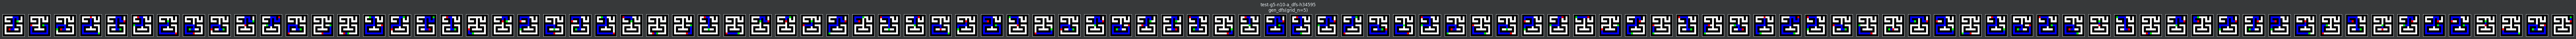

In [326]:
plot_dataset_mazes(variants_dataset)

Now, we just create filtered data sets for any direction. There will be a data set where the maze starts going in the desired direction (positive direction) and one data set where the maze goes the opposite one (negative direction). So we will have a positive and negative data set.

(<Figure size 7400x200 with 74 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

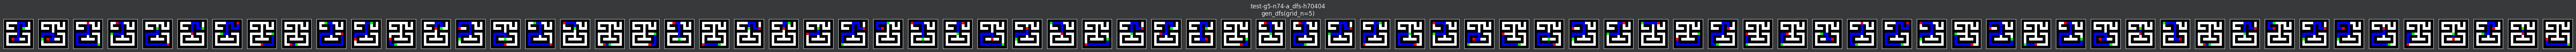

In [327]:
dataset_filtered: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : len(m.get_coord_neighbors(m.start_pos)) > 1
)

plot_dataset_mazes(dataset_filtered)

(<Figure size 10000x200 with 100 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        

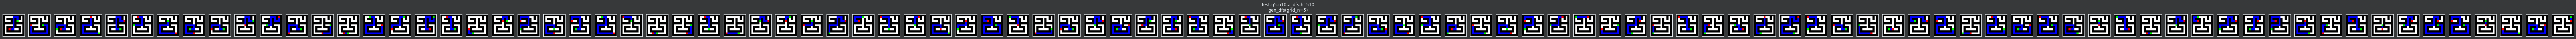

In [328]:
plot_dataset_mazes(variants_dataset)

## Creating data set that always starts with a specific direction (and its opposite)

(<Figure size 3300x200 with 33 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >], dtype=object))

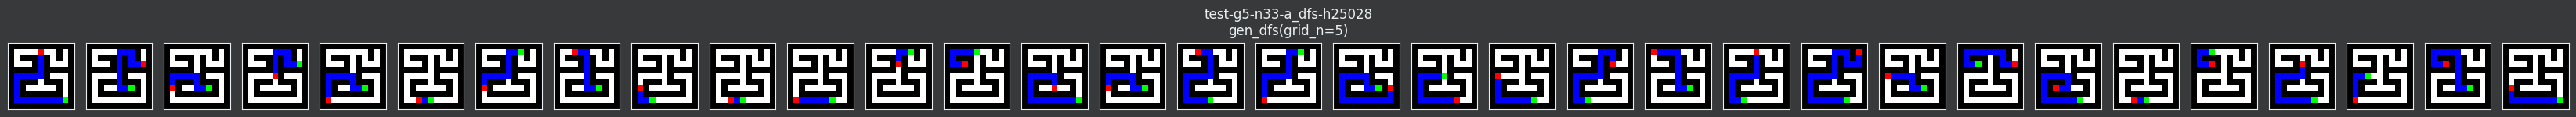

In [329]:
dataset_right: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : m.get_solution_tokens()[1][1] < m.get_solution_tokens()[2][1]
)

dataset_left: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : m.get_solution_tokens()[1][1] > m.get_solution_tokens()[2][1]
)

dataset_up: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : m.get_solution_tokens()[1][0] > m.get_solution_tokens()[2][0]
)

dataset_down: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : m.get_solution_tokens()[1][0] < m.get_solution_tokens()[2][0]
)

plot_dataset_mazes(dataset_left)

# Actual steering

In [330]:
steering_direction = 'down'

layer = 5
coeff = 5

batch_size = 1
seq_length = 106
hidden_dim = 512

shape = torch.Size([batch_size, seq_length, hidden_dim])

In [331]:
if steering_direction == 'left':
    dataset_pos = dataset_left
    dataset_neg = dataset_right
elif steering_direction == 'right':
    dataset_pos = dataset_right
    dataset_neg = dataset_left
elif steering_direction == 'up':
    dataset_pos = dataset_up
    dataset_neg = dataset_down
elif steering_direction == 'down':
    dataset_pos = dataset_down
    dataset_neg = dataset_up

In [332]:
len(dataset_pos), len(dataset_neg)

(15, 25)

In [333]:
cache_n_pos=torch.zeros(shape)
cache_n_pos = cache_n_pos.to(DEVICE)
for i in range(len(dataset_pos)):
    # Prepare example and hook
    example = dataset_pos[i].as_tokens(tokenizer)
    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    name = f"blocks.{layer}.hook_resid_pre"
    cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == name)
    with model.hooks(fwd_hooks=caching_hooks):
        _ = model(" ".join(prompt))
    cache_n_pos+= cache[name]/len(dataset_pos)

In [334]:
cache_n_neg=torch.zeros(shape)
cache_n_neg = cache_n_neg.to(DEVICE)

for i in range(len(dataset_neg)):
    # Prepare example and hook
    example = dataset_neg[i].as_tokens(tokenizer)
    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    name = f"blocks.{layer}.hook_resid_pre"
    cache, caching_hooks, _ = model.get_caching_hooks(lambda n: True)
    with model.hooks(fwd_hooks=caching_hooks):
        _ = model(" ".join(prompt))
    cache_n_neg += cache[name]/len(dataset_neg)

In [335]:
act_diff = cache_n_pos-cache_n_neg

In [336]:
def patching_hook_direction(model_in, token_to_patch, layer_to_patch, coeff, act):
    # Model in is list of str tokens (could batch tensor and use gather)
    def layer_output_patch_hook(inp, hook):
        # inp has shape [batch_size, seq_len, hidden_dim]

        if inp.shape[1] == 1:
            return  
        
        ppos, apos = inp.shape[1], act.shape[1]

        if apos <= ppos:
            inp[:, :apos, :] += coeff * act
        else:
            inp += coeff * act[:,apos-ppos:]
        
        return inp

    return [(f"blocks.{layer_to_patch}.hook_resid_post", layer_output_patch_hook)]


def patching_hook_direction2(model_in, token_to_patch, layer_to_patch, coeff, act):
    # Model in is list of str tokens (could batch tensor and use gather)
    def layer_output_patch_hook(inp, hook):
        # inp has shape [batch_size, seq_len, hidden_dim]

        matched_pos = model_in.index(token_to_patch)

        # patch inp at matched_pos
        inp[:,matched_pos] += coeff * act[:,matched_pos+1] #5 * torch.randn_like(inp[:, 0, :])#
        #print(inp)
        return inp

    return [(f"blocks.{layer_to_patch}.hook_resid_post", layer_output_patch_hook)]

In [337]:
example[example.index("<PATH_START>") : ]

['<PATH_START>',
 '(3,0)',
 '(2,0)',
 '(2,1)',
 '(2,2)',
 '(1,2)',
 '(0,2)',
 '(0,1)',
 '(0,0)',
 '(1,0)',
 '(1,1)',
 '<PATH_END>']

(<Figure size 2500x200 with 25 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >], dtype=object))

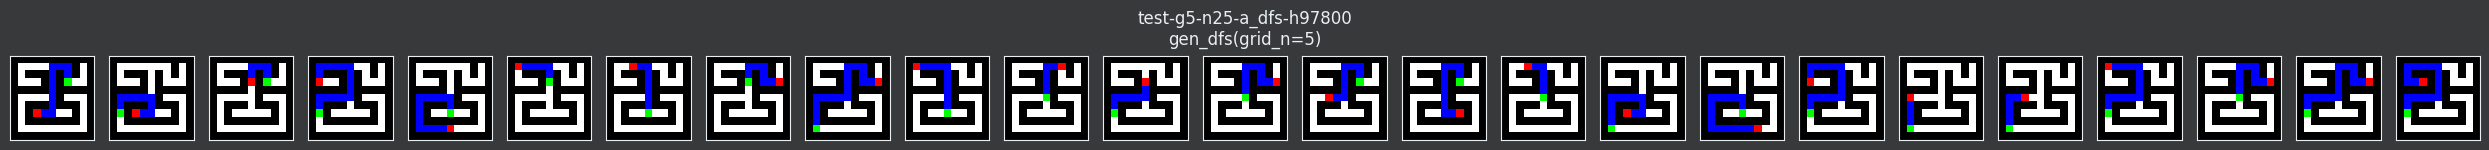

In [338]:
plot_dataset_mazes(dataset_neg)

In [422]:
# Prepare example and hook
example = dataset_left[0].as_tokens(tokenizer)
prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

direction_patch_hook = patching_hook_direction2(prompt, example[example.index("<PATH_START>") + 2], layer, 30, act_diff)


# Run intervention - generate with hook applied to same layer
#                    and token at each step of the rollout

prediction_original = model.generate(
    " ".join(prompt),
    prepend_bos=False,
    max_new_tokens=40,
    temperature=0,
    do_sample=False,
)

prediction_perturbed = intervene_upon_generation(
    model,
    " ".join(prompt),
    direction_patch_hook,
    do_sample=False,
    max_new_tokens=40,
    device=DEVICE,
)
prediction_perturbed = model.to_string(prediction_perturbed)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Layer = 5


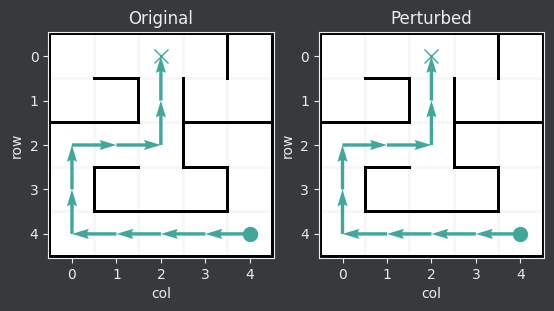

In [423]:

# Plot the output
gs = GridSpec(1, 2)

plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})
plot_maze(prediction_perturbed, tokenizer=tokenizer, ax=gs[0, 1], ax_labels={'maze':{'title': 'Perturbed'}});
print(f"Layer = {layer}")

In [368]:
per = prediction_perturbed[prediction_perturbed.index("<PATH_START>") + 1 :]
ori = prediction_original[prediction_original.index("<PATH_START>") + 1 :]

In [395]:
import numpy as np
p = np.array(tokenizer.strings_to_coords(per))
o = np.array(tokenizer.strings_to_coords(ori))

result = all(p[1] - p[0] == [-1, 0])
print(result)


True


In [344]:
def find_vector(data_set, layer):

    cache_n=torch.zeros(shape)
    cache_n = cache_n.to(DEVICE)

    for i in range(len(data_set)):
        # Prepare example and hook
        example = data_set[i].as_tokens(tokenizer)
        prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

        name = f"blocks.{layer}.hook_resid_pre"
        cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == name)
        with model.hooks(fwd_hooks=caching_hooks):
            _ = model(" ".join(prompt))
        cache_n+= cache[name]/len(data_set)

    return cache_n



In [345]:
def create_activation_vector(pos_data_set, neg_data_set, layer):

    pos_vec = find_vector(pos_data_set, layer)
    neg_vec = find_vector(neg_data_set, layer)

    return pos_vec-neg_vec

In [346]:

act_vec0 = create_activation_vector(dataset_pos, dataset_neg, 0)
act_vec1 = create_activation_vector(dataset_pos, dataset_neg, 1)
act_vec2 = create_activation_vector(dataset_pos, dataset_neg, 2)
act_vec3 = create_activation_vector(dataset_pos, dataset_neg, 3)
act_vec4 = create_activation_vector(dataset_pos, dataset_neg, 4)
act_vec5 = create_activation_vector(dataset_pos, dataset_neg, 5)
act_vec6 = create_activation_vector(dataset_pos, dataset_neg, 6)
act_vec7 = create_activation_vector(dataset_pos, dataset_neg, 7)
act_vec8 = create_activation_vector(dataset_pos, dataset_neg, 8)
act_vec9 = create_activation_vector(dataset_pos, dataset_neg, 9)
act_vec10 = create_activation_vector(dataset_pos, dataset_neg, 10)
act_vec11 = create_activation_vector(dataset_pos, dataset_neg, 11)


In [347]:
def apply_act_vecs(act_vec, layer, coeff, example):

    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    turn_right_patch_hook = patching_hook_direction2(prompt, example[example.index("<PATH_START>") + 2], layer, coeff, act_vec)

    prediction_original = model.generate(
        "".join(prompt),
        prepend_bos=False,
        max_new_tokens=40,
        do_sample=False
    )

    prediction_perturbed = intervene_upon_generation(
        model,
        "".join(prompt),
        turn_right_patch_hook,
        do_sample=False,
        max_new_tokens=40,
        device=DEVICE,
    )
    prediction_perturbed = model.to_string(prediction_perturbed)[0]


    # Plot the output
    gs = GridSpec(1, 2)
    plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})
    plot_maze(prediction_perturbed, tokenizer=tokenizer, ax=gs[0, 1], ax_labels={'maze':{'title': 'Perturbed'}});
    #print(f"Layer = {la}")


In [ ]:
example = dataset_neg[19].as_tokens(tokenizer)

apply_act_vecs(act_vec10, 10, 100, example)

IndexError: list index out of range

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

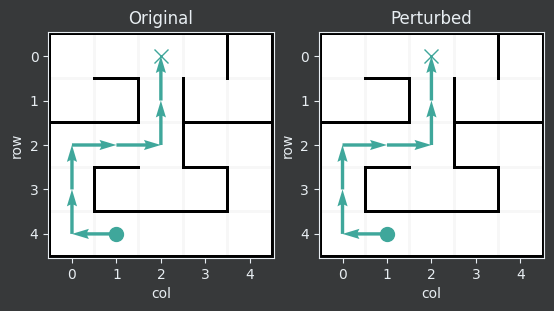

In [256]:
example = dataset_left[22].as_tokens(tokenizer)

apply_act_vecs(act_vec11, 11, 100, example)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

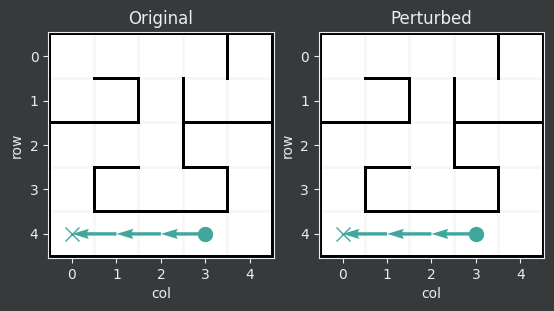

In [257]:
example = dataset_left[10].as_tokens(tokenizer)

apply_act_vecs(act_vec2, 2, 10, example)

In [258]:
example = dataset_left[13].as_tokens(tokenizer)

apply_act_vecs(act_vec7, example)

TypeError: apply_act_vecs() missing 2 required positional arguments: 'coeff' and 'example'

  0%|          | 0/40 [00:00<?, ?it/s]

  5%|▌         | 2/40 [00:00<00:06,  6.31it/s]


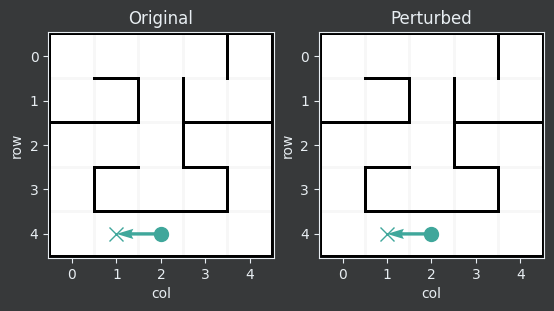

In [1144]:
example = dataset_left[9].as_tokens(tokenizer)

apply_act_vecs(act_vec7, example)

  0%|          | 0/40 [00:00<?, ?it/s]

 20%|██        | 8/40 [00:00<00:03,  8.32it/s]


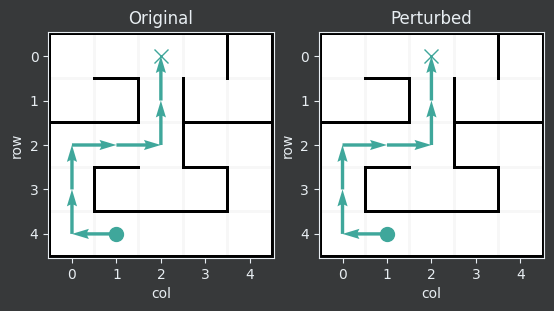

In [1145]:
example = dataset_left[22].as_tokens(tokenizer)

apply_act_vecs(act_vec7, example)

In [1095]:
act_vec2

tensor([[[ 0.1096, -2.3806, -0.0313,  ...,  0.0396,  0.1062, -0.0343],
         [ 0.1135, -2.3110, -0.0322,  ...,  0.0352,  0.0948, -0.0288],
         [ 0.0125,  0.2130,  0.0606,  ...,  0.0049,  0.0237, -0.0898],
         ...,
         [-0.0405,  0.3791, -0.0162,  ..., -0.0589,  0.1657, -0.1460],
         [ 0.1489,  0.2021,  0.0623,  ...,  0.0703, -0.0695,  0.0139],
         [-0.0057, -0.5120,  0.0624,  ...,  0.1951,  0.1051,  0.1107]]],
       device='mps:0')

In [397]:
prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

turn_right_patch_hook = patching_hook_direction2(prompt, example[example.index("<PATH_START>") + 2], layer, coeff, act_vec7)

prediction_original = model.generate(
        "".join(prompt),
        prepend_bos=False,
        max_new_tokens=40,
        do_sample=False
    )

prediction_perturbed = intervene_upon_generation(
        model,
        "".join(prompt),
        turn_right_patch_hook,
        do_sample=False,
        max_new_tokens=40,
        device=DEVICE,
    )
prediction_perturbed = model.to_string(prediction_perturbed)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [400]:
tokenizer.is_valid_path(prediction_perturbed)

AttributeError: 'MazeTokenizer' object has no attribute 'is_valid_path'

In [406]:
dataset_left[22].is_valid_path(soln)

TypeError: '<=' not supported between instances of 'int' and 'list'

In [405]:
soln

['(4,4)',
 '(4,3)',
 '(4,2)',
 '(4,1)',
 '(4,0)',
 '(3,0)',
 '(2,0)',
 '(2,1)',
 '(2,2)',
 '(1,2)',
 '(0,2)',
 '<PATH_END>']